# Importing Libraries

In [ ]:
import shutil
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import tensorflow.keras.backend as K
from tqdm import tqdm_notebook
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score

In [ ]:
import warnings 
warnings.filterwarnings("ignore")

# Merging & Preparing Data

In [ ]:
x_valid_1 = pd.read_csv("Data/x_valid_1.csv")
x_valid_2 = pd.read_csv("Data/x_valid_2.csv")
x_valid_3 = pd.read_csv("Data/x_valid_3.csv")

rem = np.load("valid_removed.npy")
x_valid_1.drop(index = rem, axis = 0, inplace = True)
x_valid_2.drop(index = rem, axis = 0, inplace = True)
x_valid_3.drop(index = rem, axis = 0, inplace = True)

x_valid_1 = np.array(x_valid_1)
x_valid_2 = np.array(x_valid_2)
x_valid_3 = np.array(x_valid_3)

valid_embedding = np.load("valid_embedding.npy")
y_val = pd.read_csv("org_valid.csv", usecols = ["label"])
y_val.drop(index = rem, axis = 0, inplace = True)

In [ ]:
x_valid = np.hstack((x_valid_1, x_valid_2, x_valid_3, valid_embedding))

In [ ]:
rem = np.load("train_removed.npy")

In [ ]:
y = pd.read_csv("org_train.csv", usecols = ["label"])
y.drop(index = rem, axis = 0, inplace = True)

In [ ]:
x1 = pd.read_csv("Data/x_train_1.csv")
x2 = pd.read_csv("Data/x_train_2.csv")
x3 = pd.read_csv("Data/x_train_3.csv")

x1.drop(index = rem, axis = 0, inplace = True)
x2.drop(index = rem, axis = 0, inplace = True)
x3.drop(index = rem, axis = 0, inplace = True)

x1 = np.array(x1)
x2 = np.array(x2)
x3 = np.array(x3)

np.save("Data/x1.npy", x1)
np.save("Data/x2.npy", x2)
np.save("Data/x3.npy", x3)

In [ ]:
x = np.load("Data/train_embedding.npy", mmap_mode = 'r')
x1 = np.load("Data/x1.npy", mmap_mode = 'r')
x2 = np.load("Data/x2.npy", mmap_mode = 'r')
x3 = np.load("Data/x3.npy", mmap_mode = 'r')

In [ ]:
a = np.memmap("Data/test", dtype = np.float32, mode = 'w+', shape = (len(x1), 101), order = 'F')

In [ ]:
a[:, :23] = x1
a[:, 23:30] = x2
a[:, 30:37] = x3
a[:, 37:] = x

# Train The Model

In [ ]:
model = Sequential([
        InputLayer(input_shape = (101)),
        Dense(100, activation = "relu", kernel_initializer = "he_normal"),
        Dropout(0.5),
        Dense(200, activation = "relu", kernel_initializer = "he_normal"),
        Dropout(0.5),
        Dense(500, activation = "relu", kernel_initializer = "he_normal"),
        Dropout(0.5),
        Dense(1, activation = "sigmoid")
])

In [ ]:
# taken from old keras source code
def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

In [ ]:
opt = tf.keras.optimizers.Nadam(learning_rate = 0.001)
model.compile(loss = "BinaryCrossentropy", optimizer = opt, metrics = ["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), get_f1])

In [ ]:
def batch_generator(Train_df, batch_size, scaler):
    idx = -1
    while True: 
        yield load_data(Train_df, idx + 1, batch_size, scaler) ## Yields data
        idx += 1
        if idx > steps_per_epoch:
          idx = 0

In [ ]:
def load_data(Train_df, idx, batch_size, scaler):
    
    x = a[idx * batch_size : (idx + 1) * batch_size, :]
    y_t = y[idx * batch_size : (idx + 1) * batch_size]
    x = scaler.transform(x)
    return (x, y_t)

In [ ]:
# def valid_generator(data, scaler):
#       yield load_valid(data, scaler)## Yields data

# def load_valid(data, scaler):
#     x = data
#     y = y_val
#     return (x, y)

# generator_valid = valid_generator(x_valid, scaler)

In [ ]:
scaler = MinMaxScaler()

In [ ]:
# c = 0
# for i in range(10):
#   for i in range(4):
#     x = a[c : (c + 5000000), :]
#     if x.shape[0] == 0:
#       c = 0
#       break
#     scaler.fit(x)
#     c += 5000000

In [ ]:
# Fitting the scaler on the train data
temp = a
scaler.fit(temp)

MinMaxScaler()

In [ ]:
x_valid = scaler.transform(x_valid)

In [ ]:
batch_size = 4096
generator = batch_generator(a, batch_size, scaler)

In [ ]:
steps_per_epoch = np.ceil(len(a) / batch_size)
print("Steps per epoch =", steps_per_epoch)

Steps per epoch = 4013.0


In [ ]:
# Initiating checkpoint callback
cb = tf.keras.callbacks.ModelCheckpoint(filepath = "model.h5", save_best_only = True, mode = "max", monitor = "val_get_f1")

In [ ]:
model.fit(generator, epochs = 10, use_multiprocessing = True, workers = 32, steps_per_epoch = steps_per_epoch, validation_data = (x_valid, y_val), callbacks = cb)

Epoch 1/10
4013/4013 [==============================] - 110s 26ms/step - loss: 0.1145 - accuracy: 0.9501 - precision: 0.9680 - recall: 0.9333 - get_f1: 0.9502 - val_loss: 0.3434 - val_accuracy: 0.9593 - val_precision: 0.9882 - val_recall: 0.9297 - val_get_f1: 0.9566
Epoch 2/10
4013/4013 [==============================] - 98s 24ms/step - loss: 0.0997 - accuracy: 0.9579 - precision: 0.9722 - recall: 0.9444 - get_f1: 0.9581 - val_loss: 0.3058 - val_accuracy: 0.9625 - val_precision: 0.9872 - val_recall: 0.9372 - val_get_f1: 0.9602
Epoch 3/10
4013/4013 [==============================] - 102s 25ms/step - loss: 0.0969 - accuracy: 0.9585 - precision: 0.9712 - recall: 0.9471 - get_f1: 0.9590 - val_loss: 0.3941 - val_accuracy: 0.9618 - val_precision: 0.9852 - val_recall: 0.9378 - val_get_f1: 0.9596
Epoch 4/10
4013/4013 [==============================] - 103s 26ms/step - loss: 0.0955 - accuracy: 0.9594 - precision: 0.9721 - recall: 0.9477 - get_f1: 0.9597 - val_loss: 0.3955 - val_accuracy: 0.9564

In [ ]:
# To save the model
# tf.keras.models.save_model(model, "model.h5")
# To load the model
# model = tf.keras.models.load_model("model.h5", custom_objects = {"get_f1": get_f1})

# Testing Model Performance

In [ ]:
# evaluation = model.evaluate(x_valid, y_val)
print("***********************************")
print("Validation Loss =", evaluation[0])
print("Validation Accuracy =", evaluation[1] * 100)
print("Validation Precision =", evaluation[2] * 100)
print("Validation Recall =", evaluation[3] * 100)
print("Validation F1 =", evaluation[4])

***********************************
Validation Loss = 0.30577710270881653
Validation Accuracy = 96.2495505809784
Validation Precision = 98.72417449951172
Validation Recall = 93.71526837348938
Validation F1 = 0.9602054357528687


In [ ]:
# To hold the prediction of batches of size 50000
temp = []
c = 0
for i in tqdm_notebook(range(500)):
    x = a[c : (c + 50000), :]
    if x.shape[0] == 0:
      c = 0
      break
    c += 50000
    # append the prediction to temp list, we are gonna extend this list later
    temp.append(model.predict(scaler.transform(x)))

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
# extend temp list (list of list) to make it as one list
y_pred = []
for lst in tqdm_notebook(temp):
  y_pred.extend(lst)

  0%|          | 0/329 [00:00<?, ?it/s]

In [ ]:
thresh = [0.38, 0.39, 0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46]

In [ ]:
# Choosing the best threshold
# Test on Train Data
for t in tqdm_notebook(thresh):
  y_predict = []
  for prediction in y_pred:
    y_predict.append(prediction > t)
  
  print("Threshold =", t)
  prec = precision_score(y, y_predict)
  rec = recall_score(y, y_predict)
  f1 = f1_score(y, y_predict)
  print("Precsion with {} Threshold = {}".format(t, prec * 100))
  print("Recall with {} Threshold = {}".format(t, rec * 100))
  print("F1 Score with {} Threshold = {}".format(t, f1 * 100))
  print("*" * 75)

  0%|          | 0/9 [00:00<?, ?it/s]

Threshold = 0.38
Precsion with 0.38 Threshold = 97.78408272658072
Recall with 0.38 Threshold = 93.36909068764628
F1 Score with 0.38 Threshold = 95.52560101235443
***************************************************************************
Threshold = 0.39
Precsion with 0.39 Threshold = 97.91847995726137
Recall with 0.39 Threshold = 93.22179429437205
F1 Score with 0.39 Threshold = 95.51243380739689
***************************************************************************
Threshold = 0.4
Precsion with 0.4 Threshold = 98.03094887655803
Recall with 0.4 Threshold = 93.09390406994983
F1 Score with 0.4 Threshold = 95.49866079587947
***************************************************************************
Threshold = 0.41
Precsion with 0.41 Threshold = 98.13281832614706
Recall with 0.41 Threshold = 92.98133638498315
F1 Score with 0.41 Threshold = 95.48764825903835
***************************************************************************
Threshold = 0.42
Precsion with 0.42 Threshold = 98.2

In [ ]:
# Test on Validation Data
for t in tqdm_notebook(thresh):
    y_valid_pred = model.predict(x_valid)
    y_valid_pred = (y_valid_pred > t)
  
    print("Threshold =", t)
    prec = precision_score(y_val, y_valid_pred)
    rec = recall_score(y_val, y_valid_pred)
    f1 = f1_score(y_val, y_valid_pred)
    print("Precsion with {} Threshold = {}".format(t, prec * 100))
    print("Recall with {} Threshold = {}".format(t, rec * 100))
    print("F1 Score with {} Threshold = {}".format(t, f1 * 100))
    print("*" * 75)

  0%|          | 0/9 [00:00<?, ?it/s]

Threshold = 0.38
Precsion with 0.38 Threshold = 97.76075878774463
Recall with 0.38 Threshold = 94.18116794966964
F1 Score with 0.38 Threshold = 95.93758485994192
***************************************************************************
Threshold = 0.39
Precsion with 0.39 Threshold = 97.89361003424642
Recall with 0.39 Threshold = 94.13892523038687
F1 Score with 0.39 Threshold = 95.97956120140663
***************************************************************************
Threshold = 0.4
Precsion with 0.4 Threshold = 98.0075443325658
Recall with 0.4 Threshold = 94.09012053529318
F1 Score with 0.4 Threshold = 96.00888866569578
***************************************************************************
Threshold = 0.41
Precsion with 0.41 Threshold = 98.107629381161
Recall with 0.41 Threshold = 94.0433664576404
F1 Score with 0.41 Threshold = 96.03251549029748
***************************************************************************
Threshold = 0.42
Precsion with 0.42 Threshold = 98.20437

In [ ]:
temp = []
c = 0
for i in tqdm_notebook(range(500)):
    x = a[c : (c + 50000), :]
    if x.shape[0] == 0:
      c = 0
      break
    c += 50000
    temp.append(model.predict(scaler.transform(x)))

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
# extend temp list (list of list) to make it as one list
y_pred = []
for lst in tqdm_notebook(temp):
  y_pred.extend(lst)

  0%|          | 0/329 [00:00<?, ?it/s]

In [ ]:
# We will stick with 0.42 as threshold to balance between precision and recall
y_predict = []
for prediction in tqdm_notebook(y_pred):
  y_predict.append(prediction > 0.42)

  0%|          | 0/16434117 [00:00<?, ?it/s]

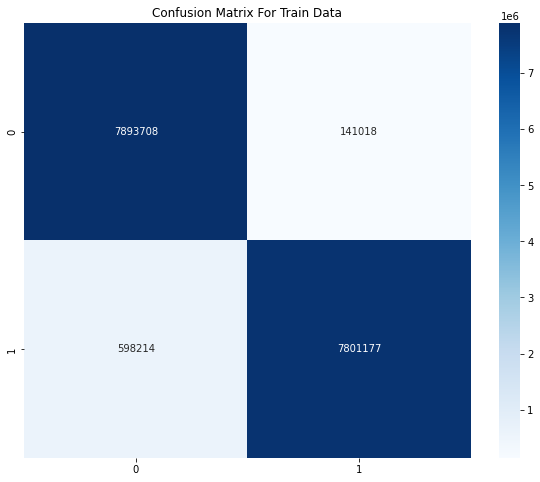

In [ ]:
# Plotting confusion matrix of the model for train data
plt.figure(figsize = (10, 8))
sns.heatmap(confusion_matrix(y, y_predict), annot = True, fmt = 'd', cmap = "Blues")
plt.title("Confusion Matrix For Train Data")
plt.show()

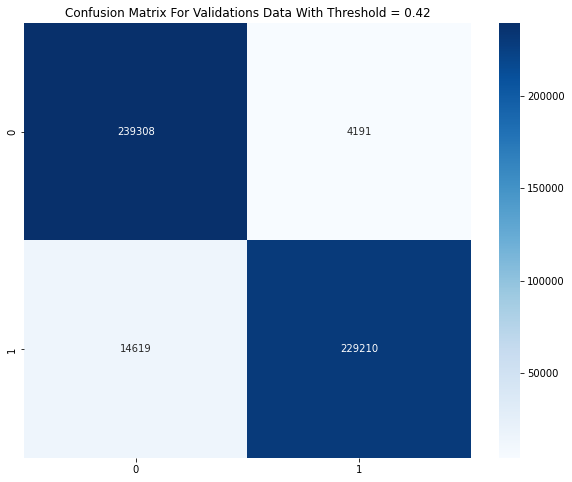

In [ ]:
y_val_predict = model.predict(x_valid)
y_val_predict = (y_val_predict > 0.42)

# Plotting confusion matrix of the model for validataion data
plt.figure(figsize = (10, 8))
sns.heatmap(confusion_matrix(y_val, y_val_predict), annot = True, fmt = 'd', cmap = "Blues")
plt.title("Confusion Matrix For Validations Data With Threshold = 0.42")
plt.show()

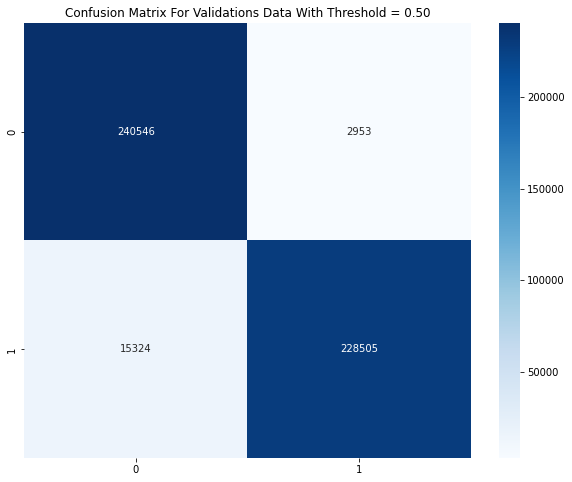

In [ ]:
y_val_predict = model.predict(x_valid)
y_val_predict = (y_val_predict > 0.50)

# Plotting confusion matrix of the model for validataion data
plt.figure(figsize = (10, 8))
sns.heatmap(confusion_matrix(y_val, y_val_predict), annot = True, fmt = 'd', cmap = "Blues")
plt.title("Confusion Matrix For Validations Data With Threshold = 0.50")
plt.show()

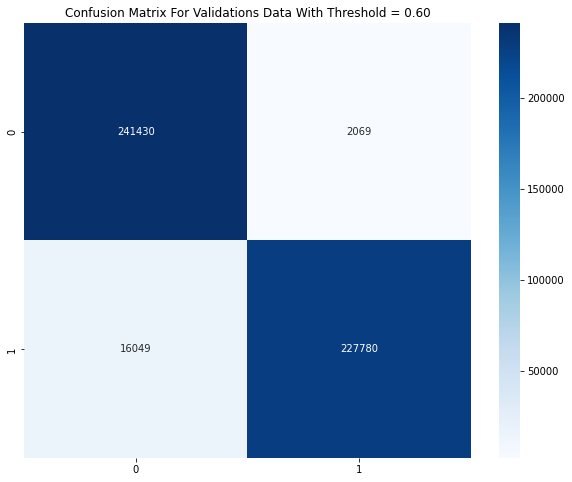

In [ ]:
y_val_predict = model.predict(x_valid)
y_val_predict = (y_val_predict > 0.60)

# Plotting confusion matrix of the model for validataion data
plt.figure(figsize = (10, 8))
sns.heatmap(confusion_matrix(y_val, y_val_predict), annot = True, fmt = 'd', cmap = "Blues")
plt.title("Confusion Matrix For Validations Data With Threshold = 0.60")
plt.show()

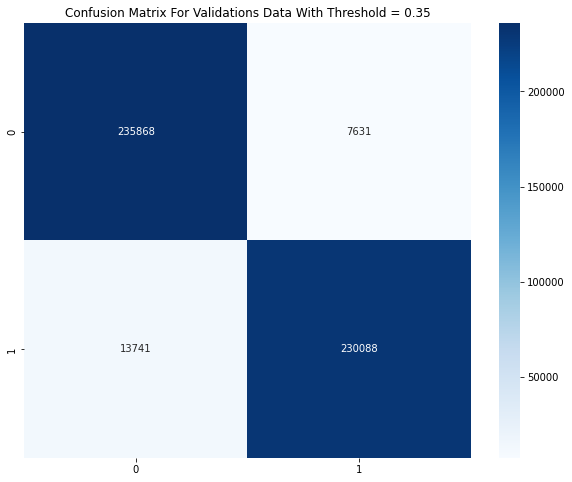

In [ ]:
y_val_predict = model.predict(x_valid)
y_val_predict = (y_val_predict > 0.35)

# Plotting confusion matrix of the model for validataion data
plt.figure(figsize = (10, 8))
sns.heatmap(confusion_matrix(y_val, y_val_predict), annot = True, fmt = 'd', cmap = "Blues")
plt.title("Confusion Matrix For Validations Data With Threshold = 0.35")
plt.show()

By changing the threshold we can change how we give recommendatiaons, so if we increase the threshold we tend to give more trust freindship recommendations but less ofcourse, on contrast if we decrease our threshold we tend to give more friendship recommendations but some of them will be false or irrelevant.